In [1]:
import h5py
import numpy as np
D = h5py.File('breast.h5','r')
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

In [2]:
from PIL import Image  # this contain the image class and methods from PIL library
import matplotlib.pyplot as plt # this is for plotting (showing) images 
from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import keras

Using TensorFlow backend.


### Question No. 1: (Showing data)[20Marks]
Load the training and test data files and answer the following questions:

i. How many training and test examples are there?[2marks]
* the number of training examples is 5841 and the number of test examples is 1563.

ii. Show some image examples using plt.imshow. Describe your observations on what you see in the images and how it correlates with the cell count (target variable).[2marks]
*  the cell count is related to the 'brown' cells.

iii. Plot the histogram of counts. How many images have counts within each of the following bins?[3 marks]
    0 (no lymphocytes)1-56-1011-2021-5051-200>200

|0|1-5|6-10|11-20|21-50|51-200|>200|
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:------:|
|1397|4811|736|356|103|1|0|

iv. Pre-processing: Convert and view afew images from RGB space to HED space and show the D channelwhich should identify  the brownelements in the image. For this purpose, you can use the color separation notebook available here: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html[5marks]

v. Do a scatter plot of the average of the brown channel for each image vs. its cell count. Do you think this feature would be useful in your regression model?Explain your reasoning. [3 marks]
* Yes, it would be useful. It can be seen that these two variables has positive correlation from the scatter plot. 

vi. What is the number of images for each patient?Do you think this can have an impact on your regression model?[2marks]

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:------:|:-------:|:------:|:-------:|:------:|
|320|465|958|192|44|105|83|632|533|552|761|791|405|105|399|604|103|352|

* In my view, the patient ID variable do not influence the regression models. Intuitively, cells with the same characteristics do not change their cell features depending on the patient, because ID would not be used in build regression models. 

vii. What performance metrics can you use for this purpose? Which one will be the best performance metric for this problem? Please give reasoning.[3 marks]
* Root Mean Square Error (RMSE),Correlation Coefficient and R2 score . R2 score will be the best performance metric for this problem.

In [4]:
# i count the training and test images
# training IDs 1-13
number_train = 0
number_test = 0
for i in P:
    if i <=13:
        number_train += 1
    else:
        number_test += 1
print('the number of training is',number_train)
print('the number of test examples is',number_test)

the number of training is 5841
the number of test examples is 1563


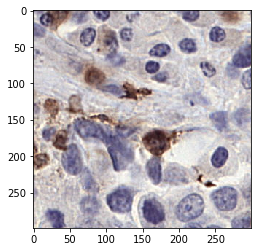

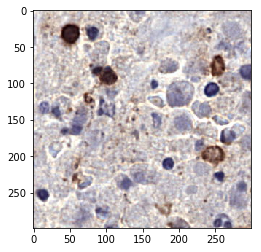

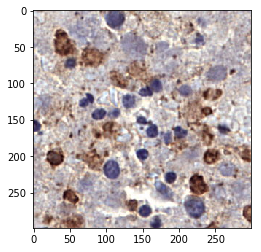

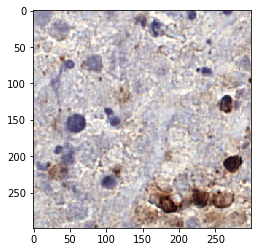

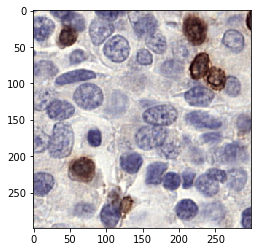

In [5]:
# ii.show top5 images
im = np.asarray(X)
for i in range(5):
    plt.imshow(im[i])
    plt.show()

In [17]:
# divide data into training data and test data
im_train=im[:5841]
im_test=im[5841:]
id_train=P[:5841]
id_test=P[5841:]
y_train=Y[:5841]
y_test=Y[5841:]


[1397 4811  736  356  103    1    0]


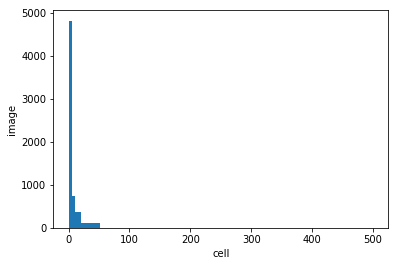

In [307]:
# iii.Plot the histogram of counts.
bins = [0,1,6,11,21,51,201,500]
hist,edge=np.histogram(Y,bins)
#show the number of images in each bin
print(hist)
plt.hist(Y,bins)
plt.xlabel('cell')
plt.ylabel('image')
plt.show()

In [21]:
#iv. Pre-processing: convert RGB to HED
hed_train = []
for i in range(len(im_train)):
    hed = rgb2hed(im_train[i])
    hed_train.append(hed)


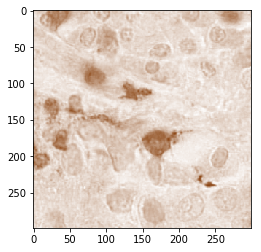

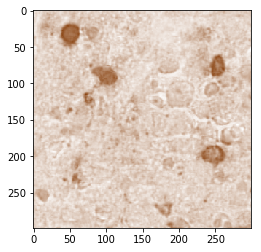

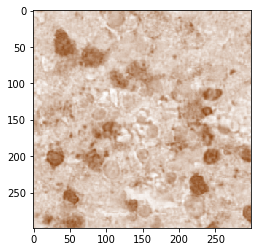

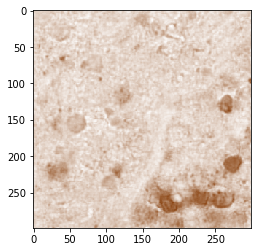

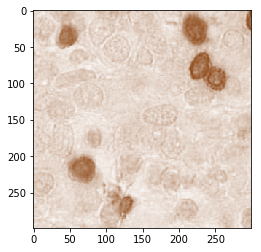

In [22]:
#iv. Pre-processing: show the images of HED space in D channel
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
for i in range(5):
    plt.imshow(hed_train[i][:, :, 2], cmap=cmap_dab)
    plt.show()

v. Do a scatter plot of the average of the brown channel for each image vs. its cell count. Do 
you think this feature would be useful in your regression model? Explain your reasoning. [3 
marks]

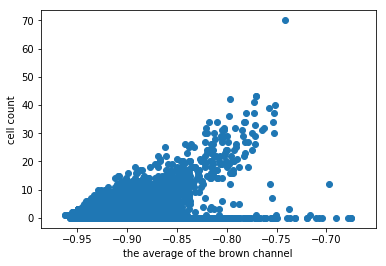

In [308]:
#v. a scatter plot of the average of the brown channel for each image vs. its cell count. 
mean_brown=[]
for i in range(len(hed_train)):
    brown = np.mean(hed_train[i][:,:,2])
    mean_brown.append(brown)
plt.scatter(mean_brown,y_train)
plt.xlabel('the average of the brown channel')
plt.ylabel('cell count')
plt.show()

In [309]:
#vi. the number of images for each patient
patient_im=np.bincount(P)
nozero=np.nonzero(patient_im)
print(patient_im[nozero])

[320 465 958 192  44 105  83 632 533 552 761 791 405 105 399 604 103 352]


### Question2

i.Extract features from agiven image. Specifically,calculate the:

a.average of the “brown”, red, green and blue channels

b.varianceof the “brown”, red, green and blue channels

c.entropy of the “brown”, red, green and blue channels

d.Histogram of each channel

e.PCA Coefficients (you may want to use randomized PCA or incremental PCA, see: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) 

f.Any other features that you think can be useful for this work. 

Describe your reasoning for using these features. Plot the scatter plot and calculate the correlation coefficient of each feature you obtain vs.the target variable (cell count)across all images. Which features do you think are important? Give your reasoning.[20 marks]
* 'average of brown' is the most important feature with the heighest correlation coefficient value(0.55393703)
* top 4 important features accroding to correlation coefficient value: ave_brown,ave_blue,entropy_blue,entropy_brown


### Question2

i. Extract features from a given image. Specifically, calculate the:


a. average of the “brown”, red, green and blue channels

In [100]:
# calculate average of each channel
def average(im1):
    im1_hed=rgb2hed(im1)
    im1_brown_ave = np.mean(im1_hed[:,:,2])
    im1_red_ave = np.mean(im1[:,:,0])
    im1_green_ave = np.mean(im1[:,:,1])
    im1_blue_ave = np.mean(im1[:,:,2])
    return(im1_brown_ave,im1_red_ave,im1_green_ave,im1_blue_ave)

b. variance of the “brown”, red, green and blue channels

In [109]:
# calculate variance of each channel
def variance(im1):
    im1_hed=rgb2hed(im1)
    im1_brown_var = np.var(im1_hed[:,:,2])
    im1_red_var = np.var(im1[:,:,0])
    im1_green_var = np.var(im1[:,:,1])
    im1_blue_var = np.var(im1[:,:,2])
    return(im1_brown_var,im1_red_var,im1_green_var,im1_blue_var)

c. entropy of the “brown”, red, green and blue channels

In [113]:
# calculate entropy of each channel
from scipy.stats import entropy
def im_entropy(im1):
    im1_hed=rgb2hed(im1)
    br = im1_hed[:,:,2]
    a,count_brown=np.unique(br,return_counts=True)
    im1_brown_entropy = entropy(count_brown)
    r = im1[:,:,0]
    a,count_red=np.unique(r,return_counts=True)
    im1_red_entropy = entropy(count_red)
    g=im1[:,:,1]
    a,count_green=np.unique(g,return_counts=True)
    im1_green_entropy = entropy(count_green)
    b=im1[:,:,2]
    a,count_blue=np.unique(b,return_counts=True)
    im1_blue_entropy = entropy(count_blue)
    return(im1_brown_entropy,im1_red_entropy,im1_green_entropy,im1_blue_entropy)

d. Histogram of each channel

In [79]:
def channel_hist(im1):
    #red channel
    r = im1[:,:,0]
    ar=np.array(r).flatten()
    plt.hist(ar)
    plt.title('Red Channel')
    plt.show()
    #green channel
    g=im1[:,:,1]
    ag=np.array(g).flatten()
    plt.hist(ag)
    plt.title('Green Channel')
    plt.show()
    b=im1[:,:,2]
    ab=np.array(b).flatten()
    plt.hist(ab)
    plt.title('Blue Channel')
    plt.show()
    #brown channel
    im1_hed = rgb2hed(im1)
    br = im1_hed[:,:,2]
    abr=np.array(br).flatten()
    plt.hist(abr)
    plt.title('Brown Channel')
    plt.show()

e. PCA Coefficients (you may want to use randomized PCA or incremental PCA

In [ ]:
#randomized PCA
from sklearn.decomposition import PCA,IncrementalPCA
#im_train_reshape = np.reshape(im_train,)
#pca = PCA(n_components=3)
#X_pca=pca.fit_transform(im_train_reshape)
im_train_reshape = np.reshape(im_train,[5841,299*299*3])
ipca = IncrementalPCA(n_components=3,batch_size=100)
X_ipca=ipca.fit_transform(im_train_reshape)

f. Any other features that you think can be useful for this work. Describe your 
reasoning for using these features.

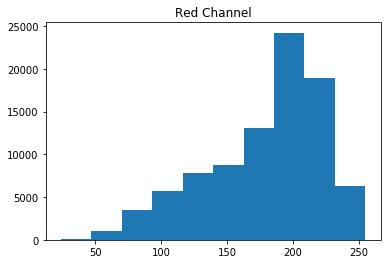

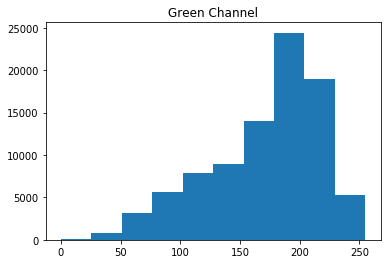

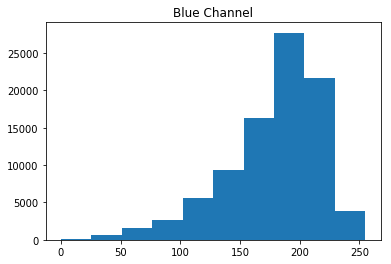

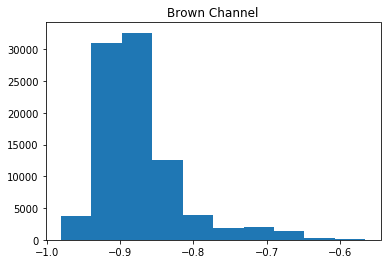

average brown,red,green,blue: (-0.8749305312890339, 179.0747083365958, 170.9491169002584, 178.14088209304145)
variance brown,red,green,blue: (0.0031447330059240957, 1921.4295144687405, 2212.668085734827, 1596.1474098727995)
entropy brown,red,green,blue: (11.398742842865289, 11.367848794959706, 11.358190087584395, 11.372237658487851)


In [104]:
# example for a given image
im_example = im[0]

print('average brown,red,green,blue:',average(im_example))
print('variance brown,red,green,blue:',variance(im_example))
print('entropy brown,red,green,blue:',im_entropy(im_example))

channel_hist(im_example)

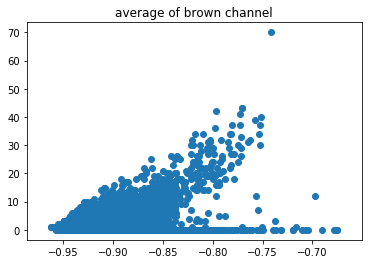

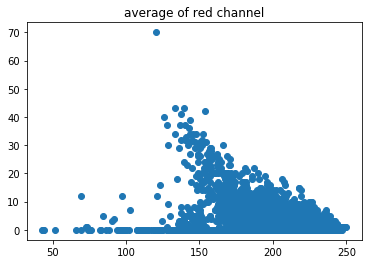

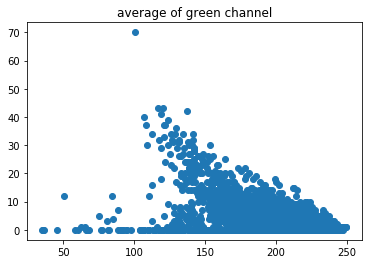

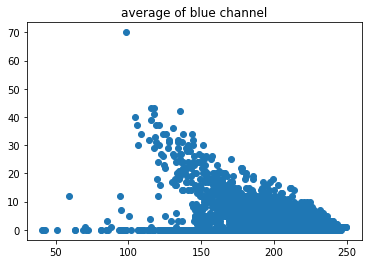

In [107]:
#average plot
ave_brown=[]
ave_red=[]
ave_green=[]
ave_blue=[]
for i in range(len(im_train)):
    abrown,ared,agreen,ablue = average(im_train[i])
    ave_brown.append(abrown)
    ave_red.append(ared)
    ave_green.append(agreen)
    ave_blue.append(ablue)
plt.scatter(ave_brown, y_train)
plt.title('average of brown channel')
plt.show()
plt.scatter(ave_red, y_train)
plt.title('average of red channel')
plt.show()
plt.scatter(ave_green, y_train)
plt.title('average of green channel')
plt.show()
plt.scatter(ave_blue, y_train)
plt.title('average of blue channel')
plt.show()


In [115]:

print('the correlation coefficient of average of brown channel and cell count',np.corrcoef(ave_brown, y_train))
print('the correlation coefficient of average of red channel and cell count',np.corrcoef(ave_red, y_train))
print('the correlation coefficient of average of green channel and cell count',np.corrcoef(ave_green, y_train))
print('the correlation coefficient of average of blue channel and cell count',np.corrcoef(ave_blue, y_train))

the correlation coefficient of average of brown channel and cell count [[1.         0.55393703]
 [0.55393703 1.        ]]
the correlation coefficient of average of red channel and cell count [[ 1.         -0.36375159]
 [-0.36375159  1.        ]]
the correlation coefficient of average of green channel and cell count [[ 1.         -0.42935362]
 [-0.42935362  1.        ]]
the correlation coefficient of average of blue channel and cell count [[ 1.         -0.49395893]
 [-0.49395893  1.        ]]


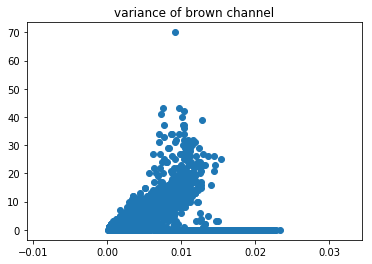

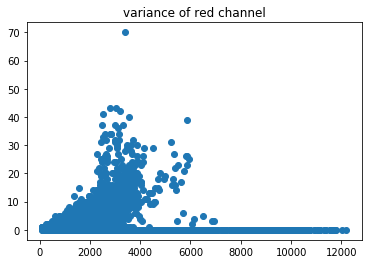

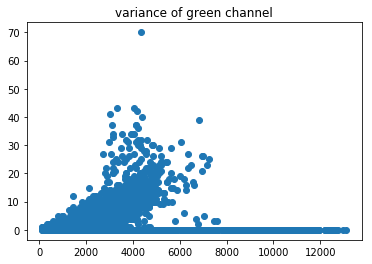

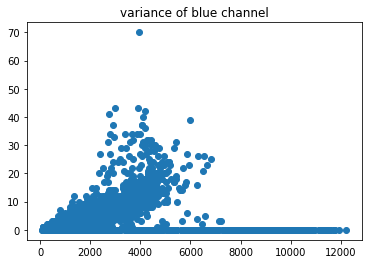

In [124]:
#variance plot
var_brown=[]
var_red=[]
var_green=[]
var_blue=[]
for i in range(len(im_train)):
    vbrown,vred,vgreen,vblue = variance(im_train[i])
    var_brown.append(vbrown)
    var_red.append(vred)
    var_green.append(vgreen)
    var_blue.append(vblue)
plt.scatter(var_brown, y_train)
plt.title('variance of brown channel')
plt.show()
plt.scatter(var_red, y_train)
plt.title('variance of red channel')
plt.show()
plt.scatter(var_green, y_train)
plt.title('variance of green channel')
plt.show()
plt.scatter(var_blue, y_train)
plt.title('variance of blue channel')
plt.show()

In [126]:
print('the correlation coefficient of variance of brown channel and cell count',np.corrcoef(var_brown, y_train))
print('the correlation coefficient of variance of red channel and cell count',np.corrcoef(var_red, y_train))
print('the correlation coefficient of variance of green channel and cell count',np.corrcoef(var_green, y_train))
print('the correlation coefficient of variance of blue channel and cell count',np.corrcoef(var_blue, y_train))

the correlation coefficient of variance of brown channel and cell count [[1.         0.38020239]
 [0.38020239 1.        ]]
the correlation coefficient of variance of red channel and cell count [[1.         0.11181155]
 [0.11181155 1.        ]]
the correlation coefficient of variance of green channel and cell count [[1.         0.19321314]
 [0.19321314 1.        ]]
the correlation coefficient of variance of blue channel and cell count [[1.         0.25729459]
 [0.25729459 1.        ]]


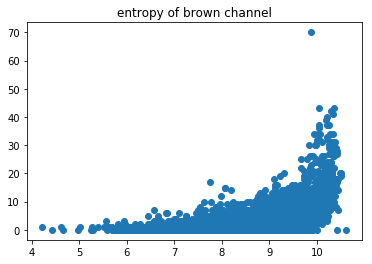

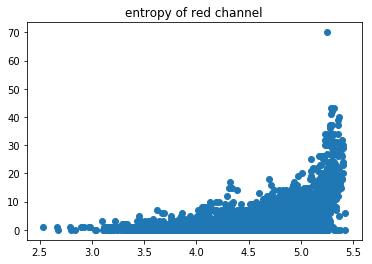

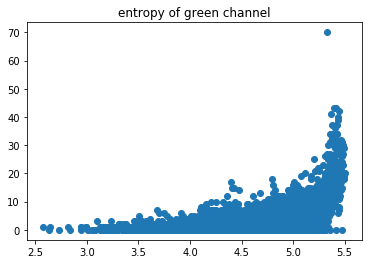

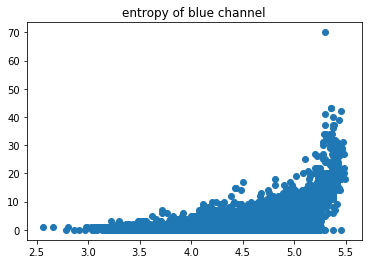

In [125]:
#entropy plot
entropy_brown=[]
entropy_red=[]
entropy_green=[]
entropy_blue=[]
for i in range(len(im_train)):
    ebrown,ered,egreen,eblue = im_entropy(im_train[i])
    entropy_brown.append(ebrown)
    entropy_red.append(ered)
    entropy_green.append(egreen)
    entropy_blue.append(eblue)
plt.scatter(entropy_brown, y_train)
plt.title('entropy of brown channel')
plt.show()
plt.scatter(entropy_red, y_train)
plt.title('entropy of red channel')
plt.show()
plt.scatter(entropy_green, y_train)
plt.title('entropy of green channel')
plt.show()
plt.scatter(entropy_blue, y_train)
plt.title('entropy of blue channel')
plt.show()

In [127]:
print('the correlation coefficient of entropy of brown channel and cell count',np.corrcoef(entropy_brown, y_train))
print('the correlation coefficient of entropy of red channel and cell count',np.corrcoef(entropy_red, y_train))
print('the correlation coefficient of entropy of green channel and cell count',np.corrcoef(entropy_green, y_train))
print('the correlation coefficient of entropy of blue channel and cell count',np.corrcoef(entropy_blue, y_train))

the correlation coefficient of entropy of brown channel and cell count [[1.         0.43710566]
 [0.43710566 1.        ]]
the correlation coefficient of entropy of red channel and cell count [[1.        0.3872314]
 [0.3872314 1.       ]]
the correlation coefficient of entropy of green channel and cell count [[1.         0.42026524]
 [0.42026524 1.        ]]
the correlation coefficient of entropy of blue channel and cell count [[1.         0.49352422]
 [0.49352422 1.        ]]


### Question2
ii. Try the following regression models with the features used in part-I. You can do 3-fold 
cross-validation analysis (https://scikit-learn.org/stable/modules/cross_validation.html)
to select feature combinations and optimal hyper-parameters for your models. Report 
your results on the test set by plotting the scatter plot between true and predicted 
counts for each type of regression model. Also, report your results in terms of RMSE, 
Correlation Coefficient and R2 score (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). [30 Marks]

a. Ordinary Least Squares (OLS) regression

b. Multilayer Perceptron (in Keras or PyTorch). 

c. Ridge Regression (Required For MSc. Students only)

d. Support Vector Regression (Required For MSc. Students only)

In [184]:
#RMSE score
from sklearn.metrics import mean_squared_error
# correlation coefficient score
from scipy.stats import pearsonr
# R2 score
from sklearn.metrics import r2_score


In [192]:
def performance(y_true, y_pred):
    print('RMSE:',np.sqrt(mean_squared_error(y_true, y_pred)))
    print('pearson correlation coefficient:',pearsonr(y_true, y_pred))
    print('R2:',r2_score(y_true, y_pred))
    return

In [207]:
def predicted_scatter(y_true, y_pred):
    plt.scatter(y_true, y_pred)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return

In [181]:
ave_brown_test=[]
ave_red_test=[]
ave_green_test=[]
ave_blue_test=[]
entropy_brown_test=[]
entropy_red_test=[]
entropy_green_test=[]
entropy_blue_test=[]
for i in range(len(im_test)):
    abrownt,aredt,agreent,abluet = average(im_test[i])
    ave_brown_test.append(abrownt)
    ave_red_test.append(aredt)
    ave_green_test.append(agreent)
    ave_blue_test.append(abluet)
    ebrownt,eredt,egreent,ebluet = im_entropy(im_test[i])
    entropy_brown_test.append(ebrownt)
    entropy_red_test.append(eredt)
    entropy_green_test.append(egreent)
    entropy_blue_test.append(ebluet)

In [182]:
#select feature(accroding tothe correlation coefficient of each feature)

#feature1 (top1&top2)
x1_train=np.transpose(np.vstack((ave_brown,ave_blue)))
x1_test=np.transpose(np.vstack((ave_brown_test,ave_blue_test)))
#feature3(top1&top2&top3)
x2_train=np.transpose(np.vstack((ave_brown,ave_blue,entropy_blue)))
x2_test=np.transpose(np.vstack((ave_brown_test,ave_blue_test,entropy_blue_test)))
#feature4(top1&top2&top3&top4)
x3_train=np.transpose(np.vstack((ave_brown,ave_blue,entropy_blue,entropy_brown)))
x3_test=np.transpose(np.vstack((ave_brown_test,ave_blue_test,entropy_blue_test,entropy_brown_test)))

In [198]:
# a. Ordinary Least Squares (OLS) regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
param_lr = {'normalize':[True,False],'n_jobs':[-1],}
print('two features:')
best_lr1 = GridSearchCV(LinearRegression(),param_lr,cv=3,n_jobs = -1)
best_lr1.fit(x1_train,y_train)
print('best parameters',best_lr1.best_params_)
pre_lr1 = best_lr1.predict(x1_test)
performance(y_test, pre_lr1)
print('================================')
print('three features:')
best_lr2 = GridSearchCV(LinearRegression(),param_lr,cv=3,n_jobs = -1)
best_lr2.fit(x2_train,y_train)
print('best parameters',best_lr2.best_params_)
pre_lr2 = best_lr2.predict(x2_test)
performance(y_test, pre_lr2)
print('================================')
print('four features:')
best_lr3 = GridSearchCV(LinearRegression(),param_lr,cv=3,n_jobs = -1)
best_lr3.fit(x3_train,y_train)
print('best parameters',best_lr3.best_params_)
pre_lr3 = best_lr3.predict(x3_test)
performance(y_test, pre_lr3)

two features:
best parameters {'n_jobs': -1, 'normalize': False}
RMSE: 3.928629262012077
pearson correlation coefficient: (0.6531080897902743, 9.896666638712276e-191)
R2: 0.4118902106428367
three features:
best parameters {'n_jobs': -1, 'normalize': True}
RMSE: 4.233242354189691
pearson correlation coefficient: (0.6340042496952949, 1.7370971389688606e-176)
R2: 0.31715429900490033
four features:
best parameters {'n_jobs': -1, 'normalize': True}
RMSE: 4.149384962812939
pearson correlation coefficient: (0.6466929886539831, 7.817785360763284e-186)
R2: 0.34393967955008664


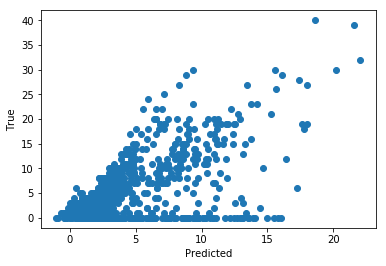

In [208]:
# a.
# the values of pcc and r2 are higher in the 'two features'models than in the other models.
# plot for OLS model
predicted_scatter(pre_lr1,y_test)

In [229]:
# b. Multilayer Perceptron
from keras.models import Sequential
from keras.layers import Dense


In [272]:
# b. performance for mlp
from sklearn.model_selection import StratifiedKFold
def mlp_performance(Xtrain,Ytrain):
    skf = StratifiedKFold(n_splits=3,shuffle = True)
    rmseall = []
    ccall = []
    r2all = []
    model = Sequential()
    model.add(Dense(2,input_dim=2,init='uniform',activation='relu'))
    model.add(Dense(1,init='uniform'))
    model.compile(loss = 'mse',optimizer='adam')
    for i,(tr_idx, v_idx) in enumerate(skf.split(Xtrain, Ytrain)):
        Xtr, Xv = Xtrain[tr_idx], Xtrain[v_idx]
        ytr, yv = Ytrain[tr_idx], Ytrain[v_idx]
        model.fit(Xtr,ytr,nb_epoch = 100, batch_size = 4,verbose=0)
        mlp_predict = model.predict(Xv)
        predicelist=[i[0] for i in mlp_predict]
        rmsei=np.sqrt(mean_squared_error(yv, mlp_predict))
        cci=np.corrcoef(yv, predicelist)
        r2i=r2_score(yv, mlp_predict)
        rmseall.append(rmsei)
        ccall.append(cci)
        r2all.append(r2i)  
    print("RMSE: Mean is %f, Stdev is %f"%(np.mean(rmseall),np.std(rmseall)))
    print("pcc: Mean is %f, Stdev is %f"%(np.mean(ccall),np.std(ccall)))
    print("R2: Mean is %f, Stdev is %f"%(np.mean(r2all),np.std(r2all)))
    return


In [273]:
#b.
mlp_performance(x1_train,y_train)

/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=2, activation="relu", kernel_initializer="uniform")`
  
/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`
  if __name__ == '__main__':
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.

RMSE: Mean is 4.059500, Stdev is 0.156393
pcc: Mean is 0.736315, Stdev is 0.263905
R2: Mean is 0.207100, Stdev is 0.023196


/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=2, activation="relu", kernel_initializer="uniform")`
  
/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/local/java/python-pip-packages.cs909/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


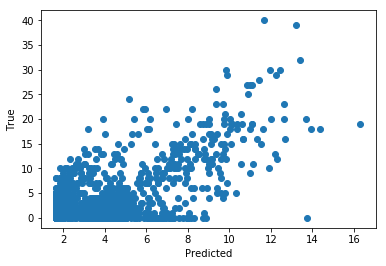

In [271]:
# b. plot for Multilayer Perceptron
model = Sequential()
model.add(Dense(2,input_dim=2,init='uniform',activation='relu'))
model.add(Dense(1,init='uniform'))
model.compile(loss = 'mse',optimizer='adam')
model.fit(x1_train,y_train,nb_epoch = 100, batch_size = 10,verbose=0)
mlp_test = model.predict(x1_test)
predicted_scatter(mlp_test,y_test)

In [214]:
# c. Ridge Regression
from sklearn.linear_model import Ridge
param_Ridge = {'alpha':[10,1.0,0.1],'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],}
print('two features:')
best_Ridge1 = GridSearchCV(Ridge(),param_Ridge,cv=3)
best_Ridge1.fit(x1_train,y_train)
print('best parameters',best_Ridge1.best_params_)
pre_Ridge1 = best_Ridge1.predict(x1_test)
performance(y_test, pre_Ridge1)
print('================================')
print('three features:')
best_Ridge2 = GridSearchCV(Ridge(),param_Ridge,cv=3)
best_Ridge2.fit(x2_train,y_train)
print('best parameters',best_Ridge2.best_params_)
pre_Ridge2 = best_Ridge2.predict(x2_test)
performance(y_test, pre_Ridge2)
print('================================')
print('four features:')
best_Ridge3 = GridSearchCV(Ridge(),param_Ridge,cv=3)
best_Ridge3.fit(x3_train,y_train)
print('best parameters',best_Ridge3.best_params_)
pre_Ridge3 = best_Ridge3.predict(x3_test)
performance(y_test, pre_Ridge3)

two features:
best parameters {'alpha': 0.1, 'solver': 'auto'}
RMSE: 3.802585675598398
pearson correlation coefficient: (0.6893076201260693, 9.06059407133258e-221)
R2: 0.44902190898723193
three features:
best parameters {'alpha': 0.1, 'solver': 'auto'}
RMSE: 3.947592164772984
pearson correlation coefficient: (0.6674356103604735, 4.10897495514548e-202)
R2: 0.40619907352351514
four features:
best parameters {'alpha': 0.1, 'solver': 'svd'}
RMSE: 3.8833714326742994
pearson correlation coefficient: (0.6798342566804987, 1.7297145003488265e-212)
R2: 0.42536221789404327


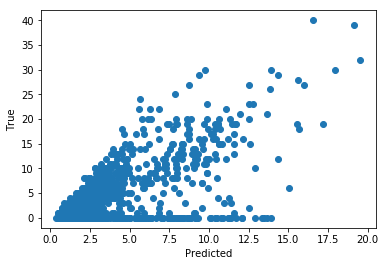

In [215]:
# c.
# the values of all scores are higher in the 'two features'models than in the other models.
# plot for Ridge model
predicted_scatter(pre_Ridge1,y_test)

In [227]:
# d. Support Vector Regression
from sklearn.svm import SVR
param_svr = {'gamma':['scale','auto'],'epsilon':[0.01,0.5],'shrinking':[True,False]}
print('two features:')
best_svr1 = GridSearchCV(SVR(),param_svr,cv=3)
best_svr1.fit(x1_train,y_train)
print('best parameters',best_svr1.best_params_)
pre_svr1 = best_svr1.predict(x1_test)
performance(y_test, pre_svr1)
print('================================')
print('three features:')
best_svr2 = GridSearchCV(SVR(),param_svr,cv=3)
best_svr2.fit(x2_train,y_train)
print('best parameters',best_svr2.best_params_)
pre_svr2 = best_svr2.predict(x2_test)
performance(y_test, pre_svr2)
print('================================')
print('four features:')
best_svr3 = GridSearchCV(SVR(),param_svr,cv=3)
best_svr3.fit(x3_train,y_train)
print('best parameters',best_svr3.best_params_)
pre_svr3 = best_svr3.predict(x3_test)
performance(y_test, pre_svr3)

two features:
best parameters {'epsilon': 0.5, 'gamma': 'auto', 'shrinking': False}
RMSE: 4.8083495362608595
pearson correlation coefficient: (0.4164082022828813, 1.3649652058210155e-66)
R2: 0.11901528117341464
three features:
best parameters {'epsilon': 0.5, 'gamma': 'auto', 'shrinking': False}
RMSE: 4.486915672029776
pearson correlation coefficient: (0.5394419683820374, 1.0070849714609738e-118)
R2: 0.23286441451701023
four features:
best parameters {'epsilon': 0.5, 'gamma': 'auto', 'shrinking': True}
RMSE: 4.121259954529448
pearson correlation coefficient: (0.637818578089634, 2.994983365505071e-179)
R2: 0.35280324281714603


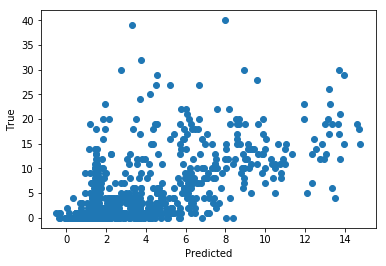

In [269]:
# d. plot for svr
predicted_scatter(pre_svr3,y_test)

### Question3
Use a convolutional neural network (in Keras or PyTorch) to solve this problem by directly in much 
the same was as in part (ii) of Question (ii). You are to develop an architecture of the neural network 
that takes an image directly as input and produces a count as the output. You are free to choose any 
network structure as long as you can show that it gives good cross-validation performance. Report 
your results on the test set by plotting the scatter plot between true and predicted counts for each 
type of regression model. Also, report your results in terms of RMSE, Correlation Coefficient and R2 
score. You will be evaluated on the design on your machine learning model, cross-validation and 
final performance metrics. Try to get the best test performance you can.
Based on your models, you may want to participate in the challenge as well and report your
challenge scores (optional but will you can get a bonus if your rank high in the challenge).

In [295]:
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
#build CNN model

cnn = Sequential()
#cnn.add(Conv2D(filters= 32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=(28,28,1)))
cnn.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(299,299,3),activation='relu'))
cnn.add(BatchNormalization(axis=-1))
cnn.add(MaxPooling2D(pool_size=(3,3)))
cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
#cnn.add(Conv2D(filters= 64, kernel_size=(3,3), padding='Same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(3,3)))
#cnn.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#cnn.add(Dropout(0.25))
cnn.add(Flatten())
#cnn.add(Dense(256, activation='relu')) 
cnn.add(Dense(516,activation='relu'))
#cnn.add(Dropout(0.25))
#cnn.add(Dense(10,activation='softmax'))
cnn.add(Dense(1))
#optimizer = RMSprop(lr=0.001,decay=0.0)
#cnn.compile(optimizer=optimizer,loss='categorical_crossentropy')
cnn.compile(loss = 'mse',optimizer='adam')
cnn.fit(im_train, y_train, epochs=10, batch_size=64,validation_split=0.2)


Train on 4672 samples, validate on 1169 samples
Epoch 1/10
4672/4672 [==============================] - 338s 72ms/step - loss: 3486.3823 - val_loss: 16.6517
Epoch 2/10
4672/4672 [==============================] - 339s 73ms/step - loss: 15.8010 - val_loss: 12.4675
Epoch 3/10
4672/4672 [==============================] - 340s 73ms/step - loss: 11.8158 - val_loss: 6.1597
Epoch 4/10
4672/4672 [==============================] - 337s 72ms/step - loss: 8.2112 - val_loss: 4.3195
Epoch 5/10
4672/4672 [==============================] - 337s 72ms/step - loss: 6.8518 - val_loss: 4.4825
Epoch 6/10
4672/4672 [==============================] - 336s 72ms/step - loss: 6.5066 - val_loss: 4.3369
Epoch 7/10
4672/4672 [==============================] - 344s 74ms/step - loss: 5.7650 - val_loss: 6.9391
Epoch 8/10
4672/4672 [==============================] - 346s 74ms/step - loss: 6.1477 - val_loss: 4.7861
Epoch 9/10
4672/4672 [==============================] - 340s 73ms/step - loss: 5.3697 - val_loss: 4.3364


NameError: name 'best_cnn1' is not defined

In [299]:
pre_cnn = cnn.predict(im_test)
print('RMSE:',np.sqrt(mean_squared_error(y_test, pre_cnn)))
pre_cnnlist=[i[0] for i in pre_cnn]
print('pearson correlation coefficient:',np.corrcoef(y_test, pre_cnnlist))
print('R2:',r2_score(y_test, pre_cnn))

RMSE: 3.9180820081965684
pearson correlation coefficient: [[1.         0.73687419]
 [0.73687419 1.        ]]
R2: 0.41504378723974145


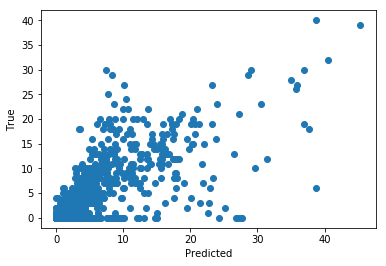

In [300]:
#plot
predicted_scatter(pre_cnn1,y_test)